In [1]:
import glob
from io import open
import pandas as pd
from pandas import DataFrame as df
from os import path
import re
import gensim
import numpy as np
from collections import Counter

In [2]:
import nltk

In [3]:
from nltk import word_tokenize

In [4]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [5]:
from tools import get_psycinfo_database

In [6]:
words_df = get_psycinfo_database()

In [7]:
words_df.head()

,Abstract,Accession Number,Author(s),Type of Book,PsycINFO Classification Code,Conference,Document Type,Grant/Sponsorship,Key Concepts,Institution,...,Population Group,Publication Status,Publication Type,Publisher,Cited References,Title,Tests & Measures,Volume,Date,Term
0,Discussion in multicultural counselling has fo...,Peer Reviewed Journal: 2001-16471-005.,"Daya, Roshni",NaN,Psychotherapy & Psychotherapeutic Counseling [...,NaN,Journal Article,NaN,multicultural counseling with principles of ch...,"Daya, Roshni: U Calgary, Dept of Educational P...",...,Human,NaN,Journal\n\nPeer Reviewed Journal,Canadian Counselling Association; Canada,NaN,Changing the face of multicultural counselling...,NaN,35,2001,multicultural
1,Investigated 181 counsellors' (mean age 46.5 y...,Peer Reviewed Journal: 2001-16471-004.,"Arthur, Nancy\n\nJanuszkowski, Tania",NaN,Professional Ethics & Standards & Liability [3...,NaN,Journal Article,NaN,"multicultural counseling competencies, Canadia...","Arthur, Nancy: U Calgary, Faculty of Education...",...,Human. Male. Female. Adulthood (18 yrs & older),NaN,Journal\n\nPeer Reviewed Journal,Canadian Counselling Association; Canada,"Allison, K., Crawford, I., Echemendia, R., Rob...",The multicultural counselling competencies of ...,NaN,35,2001,multicultural
2,P. Pederson's 3 main criticisms of professiona...,Peer Reviewed Journal: 2001-16471-003.,"Pettifor, Jean L",NaN,Professional Ethics & Standards & Liability [3...,NaN,Journal Article,NaN,professional codes of ethics & multicultural c...,"Pettifor, Jean L.: U Calgary, Calgary, AB, Canada",...,Human,NaN,Journal\n\nPeer Reviewed Journal,Canadian Counselling Association; Canada,American Counseling Association. (1995). Code ...,Are professional codes of ethics relevant for ...,NaN,35,2001,multicultural
3,The fields of psychology and particularly of c...,Peer Reviewed Journal: 2001-16471-002.,"Pedersen, Paul B",NaN,Psychotherapy & Psychotherapeutic Counseling [...,NaN,Journal Article,NaN,multiculturalism & paradigm shift in counseling,"Pedersen, Paul B.: U Alabama, Dept of Human St...",...,Human,NaN,Journal\n\nPeer Reviewed Journal,Canadian Counselling Association; Canada,"Albee, G. W. (1994). The sins of the fathers: ...",Multiculturalism and the paradigm shift in cou...,NaN,35,2001,multicultural
4,Introduces the special theme issue of the Cana...,Peer Reviewed Journal: 2001-16471-001.,"Arthur, Nancy\n\nStewart, John",NaN,Psychotherapy & Psychotherapeutic Counseling [...,NaN,Journal Article,NaN,multicultural counselling in new millennium,"Arthur, Nancy: U Calgary, Faculty of Education...",...,Human,NaN,Journal\n\nPeer Reviewed Journal,Canadian Counselling Association; Canada,"Amundson, N., Westwood, M., & Prefontaine, R. ...",Multicultural counselling in the new millenniu...,NaN,35,2001,multicultural


## Generate Corpora

In [8]:
words_to_replace = {"/":"-", "bi-ethnic": "biethnic", "bi-racial": "biracial", 
                    "mono-ethnic": "monoethnic", "poly-ethnic": "polyethnic", 
                    "mono-racial": "monoracial", "multi-racial": "multiracial",
                    "inter-racial": "interracial", "mono-cultural": "monocultural",
                    "bi-cultural": "bicultural", "multi-cultural": "multicultural",
                    "other ethnicity":"other-ethnicity", "other race": "other-race", 
                    "mixed race": "mixed-race", "mixed ethnicity": "mixed-ethnicity"}

In [9]:
def FixText(text):
    for old, new in words_to_replace.items():
        text = text.replace(old, new)
    return text

In [10]:
abstracts = [FixText(x.lower()) for x in words_df.Abstract.fillna("").values]

In [11]:
abstract_text = [word_tokenize(x) for x in abstracts]

In [12]:
abstract_text[0][:10]

['discussion',
 'in',
 'multicultural',
 'counselling',
 'has',
 'focused',
 'on',
 'whether',
 'the',
 'culture']

In [13]:
print("Number of Abstracts", len(abstract_text))
print("Number of words", sum(len(x) for x in abstract_text))

Number of Abstracts 28305
Number of words 5982943


In [14]:
model = gensim.models.Word2Vec(sentences=abstract_text, size=16, window=5, min_count=2, sample=0,
                               workers=10, hs=1, sg=1, cbow_mean=0)

In [15]:
len(model.vocab.keys())

43460

In [16]:
model.most_similar_cosmul("multicultural")

[('cross-cultural', 0.9751138687133789),
 ('mentoring', 0.9719057679176331),
 ('competence', 0.9671137928962708),
 ('counsellor', 0.9646226167678833),
 ('globalization-cultural', 0.9614262580871582),
 ('competency', 0.9608816504478455),
 ('intercultural', 0.9585008025169373),
 ('counseling', 0.9583138823509216),
 ('building', 0.9577609896659851),
 ('advising', 0.9577390551567078)]

In [17]:
model.most_similar_cosmul("biracial")

[('multiracial', 0.9735256433486938),
 ('black-white', 0.963637113571167),
 ('biethnic', 0.9539998173713684),
 ('ancestry', 0.9502686262130737),
 ('couples', 0.9479342103004456),
 ('asian-white', 0.9450501799583435),
 ('color', 0.9440266489982605),
 ('intermarried', 0.9414668679237366),
 ('mixed-race', 0.938458263874054),
 ('transracially', 0.9382955431938171)]

In [18]:
model.most_similar_cosmul("monoracial")

[('inauthenticity', 0.9711282253265381),
 ('nonwhite', 0.9683036208152771),
 ('single-race', 0.9670130610466003),
 ('nonanxious', 0.9656296372413635),
 ('asian-white', 0.9614152908325195),
 ('same-race', 0.9613317847251892),
 ('biracials', 0.960681676864624),
 ('mutltiracials', 0.9588229656219482),
 ('same-ethnicity', 0.9586841464042664),
 ('ancestry', 0.9570321440696716)]

In [19]:
model.most_similar_cosmul("bicultural", topn=10)

[('ethnic-racial', 0.9594826102256775),
 ('group', 0.9570589065551758),
 ('statuses', 0.9570267796516418),
 ('identification', 0.9545855522155762),
 ('affirmation', 0.9505467414855957),
 ('racial', 0.9486512541770935),
 ('self-identity', 0.9467672109603882),
 ('self-identification', 0.9463033080101013),
 ('matching', 0.9458569884300232),
 ('identity', 0.9441278576850891)]

## Hierchical Clustering

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [21]:
words = ['monocultural', 'monoracial', 'bicultural', 'biracial', 'biethnic', 'interracial',
        'multicultural', 'multiracial', 'multiethnic', 'polycultural', 'polyracial', 'polyethnic',
        'mixed race', 'mixed ethnicity', 'other race', 'other ethnicity', 'multiculturalism', 'polyculturalism',
         'cultural pluralism']

In [22]:
expansion = []
for w in words:
    if w in model:
        expansion.extend([x for x,y in model.most_similar(w, topn=50)])
counter = Counter(expansion)
expansion = [x for x, y in counter.items() if y > 2]

In [23]:
y = []
X = []
for w in set(words + expansion):
    if w in model:
        X.append(model[w])
        y.append(w)
X = np.asarray(X)
X = (X.T / np.linalg.norm(X, axis=1)).T

In [24]:
X.shape

(26, 16)

In [25]:
Z = linkage(X, 'ward')

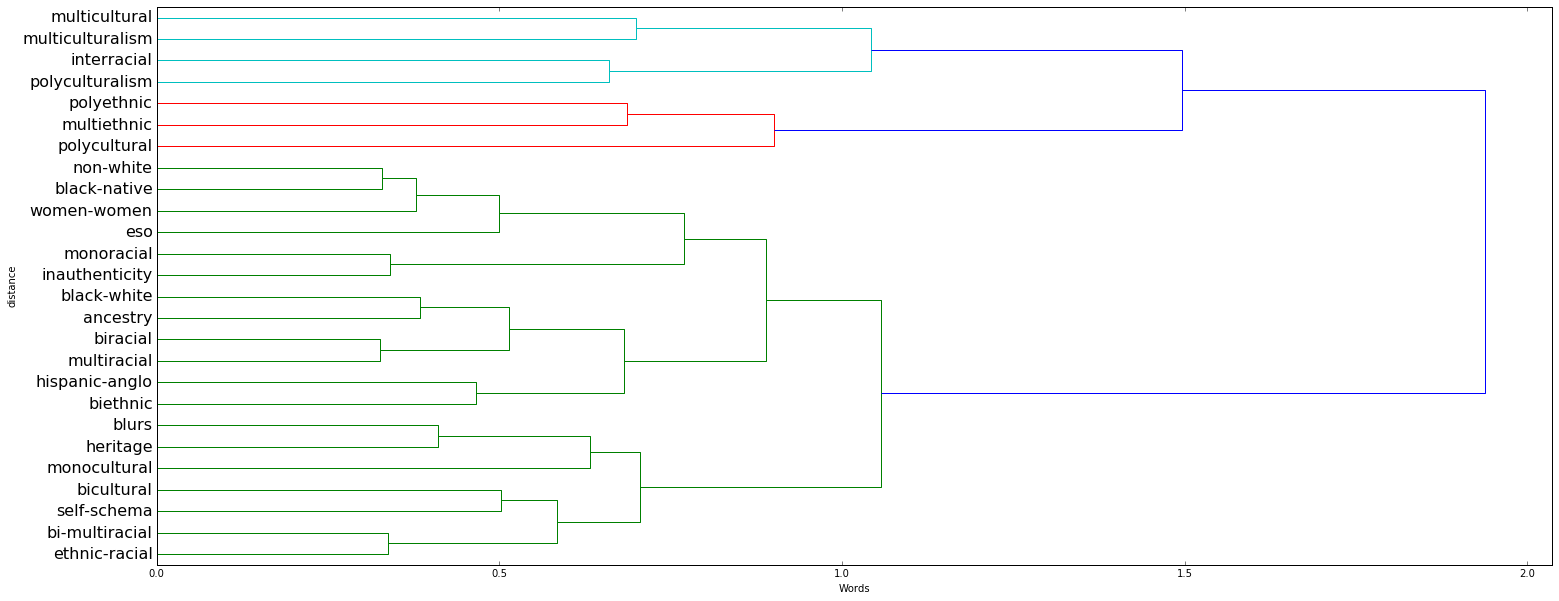

In [36]:
plt.figure(figsize=(25, 10))
#plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Words')
plt.ylabel('distance')
#color_threshold=0.9
_ = dendrogram(Z,   orientation="left", labels=y, leaf_rotation=0., leaf_font_size=16.)

## TODOs

1. Foo
1. Bar
